# III - `Process Data`

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

import transit
import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=14, usetex=True)

import astropy
from astropy import constants as const
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.table import Table

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema, medfilt
from random import uniform, randrange

import kplr
from kplr.ld import get_quad_coeffs

import time
from collections import Counter

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Introduction

## Load the data

In [2]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [3]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

Check files:
*Lengths don't match: 56 429
	Some systems have both sc and lc data! Remove duplicates.
*Lengths match: 56 56
	Duplicates have been removed.
 A total of 56 systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet


(56, 141)

## Define the Systems

In [4]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans,dt_trans,
                res_transfit, P_distribution, MCMC_transits):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
        #self.depth = rprs ** 2 
            # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and 
            # neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), 
            # to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        self.res_transfit = np.empty(0)
        self.P_distribution = np.empty(0)
        self.MCMC_transits = np.empty(0)
        
    def Print(self):
        print("System {}".format(self.kepid))
        print('rho={0:0.3f}, logg={1:0.3f} [log10(cm/s**2)], a={2:0.3f} [AU]'.format(self.srho, self.logg,self.sma))
        print("Impact parameter b:",self.b)
        print("Depth {0:0.2f} (or {1:0.2f} in ppm)".format(self.depth, self.depth*1e6))
        print("u1: {0:0.3f}, u2: {1:0.3f}".format(self.u1,self.u2))
        print("Temperature [K]:",self.teff)

## Characterize the Systems

Some initialization functions

In [5]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

Create the planet+star system.

In [6]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    #rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
    #rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
    
    #smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
    #smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    time0bk = getattr(row, "koi_time0bk")
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.abs((rp_errPos+rp_errNeg)/2.)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Transit Detection

In [7]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [8]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.')     
        plt.title(r'Folded LC for KID'+str(star.kepid))
        plt.xlabel(r'Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.3)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title(r'KID'+str(star.kepid))
        plt.xlabel(r'Time BKJD [d]'); plt.ylabel(r'Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.3)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                plt.figure(figsize=(15,6))
                plt.title('Folded Light Curve')
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.')     
                plt.title("Transit "+str(i+1))
                plt.xlabel(r'Time [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.3)
                plt.close()

In [9]:
def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
        
    star.trans_id = flag_transit
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [10]:
def oot_fit(star, polyorder, factor):
    window = factor*star.duration 
    transit_range = window/2 # In days
    for i in range(0, len(star.transit_times)):
        transitBool = (star.trans_id == i)
        outsideBool = (np.abs(star.dt_trans) >= transit_range) & transitBool
        f_out = star.ftrans[outsideBool]
        num_oot_points = len(star.dt_trans[outsideBool])
        rms = np.sqrt(np.mean(f_out**2))
        
        if  (num_oot_points!= 0):  
            z = np.polyfit(star.dt_trans[outsideBool], f_out, polyorder)
            p = np.poly1d(z)
            star.ftrans[transitBool] = star.ftrans[transitBool]/p(star.dt_trans[transitBool]) # Divide transit by fit.
            
            snr_trans = np.mean(star.ftrans[transitBool])/np.std(star.ftrans[transitBool])
            print("Transit #{0:s}: \t RMS={1:0.5f}\tflux_min={2:0.4f}".format(str(i+1),rms,min(star.ftrans[transitBool])))

In [11]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [12]:
stars_wo_transits = []
medfilter = 13
poly_order = 2
amplify = 1.5

In [13]:
for target in targets:
    print("\n**** KID"+str(target.kepid)+" ****\n")
    
    target.flux = sig.medfilt(target.flux, medfilter)
    target.transit_times = find_transits(target)
    get_data_in_transit(target, amplify)
    oot_fit(target, poly_order, amplify)
       
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)
    
    target.ind_missed_transits = find_missed_transits(target)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)

    if len(observed_transits!=0): 
        show_folded_lightcurve(target, False)
    
    print("Transit duration:", target.duration)
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)


**** KID5009743 ****

Transit #1: 	 RMS=1.00008	flux_min=0.9989
Transit duration: 0.23769583333333333
Period: 41.6980186 [d]
Estimated transits at (1): [878.4417962]
Observed transits at (1): [878.4417962]
Index of missed transits: []

**** KID8802165 ****

Transit #1: 	 RMS=1.00037	flux_min=0.9985
Transit #2: 	 RMS=1.00009	flux_min=0.9978
Transit duration: 0.208225
Period: 17.42115972 [d]
Estimated transits at (2): [759.14417676 776.56533648]
Observed transits at (2): [759.14417676 776.56533648]
Index of missed transits: []

**** KID6471021 ****



/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Transit #2: 	 RMS=0.99646	flux_min=0.9935
Transit #7: 	 RMS=1.00612	flux_min=0.9918
Transit #8: 	 RMS=0.98220	flux_min=0.9915
Transit #9: 	 RMS=1.00731	flux_min=0.9918
Transit duration: 0.3795
Period: 125.6291479 [d]
Estimated transits at (9): [ 504.6090858  630.2382337  755.8673816  881.4965295 1007.1256774
 1132.7548253 1258.3839732 1384.0131211 1509.642269 ]
Observed transits at (4): [ 630.2382337 1258.3839732 1384.0131211 1509.642269 ]
Index of missed transits: [5, 4, 3, 2, 0]

**** KID11133306 ****

Transit #1: 	 RMS=0.99998	flux_min=0.9994
Transit #2: 	 RMS=1.00001	flux_min=0.9994
Transit #3: 	 RMS=0.99999	flux_min=0.9995
Transit #4: 	 RMS=1.00002	flux_min=0.9994
Transit #5: 	 RMS=1.00000	flux_min=0.9997
Transit #6: 	 RMS=0.99996	flux_min=0.9993
Transit #7: 	 RMS=0.99998	flux_min=0.9993
Transit #8: 	 RMS=1.00000	flux_min=0.9994
Transit #9: 	 RMS=0.99995	flux_min=0.9993
Transit #10: 	 RMS=1.00001	flux_min=0.9994
Transit #11: 	 RMS=1.00001	flux_min=0.9994
Transit #12: 	 RMS=1.00001

Transit #1: 	 RMS=1.00028	flux_min=0.9959
Transit #3: 	 RMS=1.00125	flux_min=0.9966
Transit #4: 	 RMS=0.99964	flux_min=0.9967
Transit #5: 	 RMS=0.99931	flux_min=0.9969
Transit #6: 	 RMS=0.99959	flux_min=0.9959
Transit #7: 	 RMS=1.00087	flux_min=0.9954
Transit #9: 	 RMS=1.00053	flux_min=0.9956
Transit #10: 	 RMS=0.99936	flux_min=0.9958
Transit #11: 	 RMS=1.00030	flux_min=0.9950
Transit duration: 0.08083333333333333
Period: 18.47762694 [d]
Estimated transits at (11): [1275.44905046 1293.9266774  1312.40430434 1330.88193128 1349.35955822
 1367.83718516 1386.3148121  1404.79243904 1423.27006598 1441.74769292
 1460.22531986]
Observed transits at (9): [1275.44905046 1312.40430434 1330.88193128 1349.35955822 1367.83718516
 1386.3148121  1423.27006598 1441.74769292 1460.22531986]
Index of missed transits: [7, 1]

**** KID8950853 ****

Transit #1: 	 RMS=1.00006	flux_min=0.9987
Transit duration: 0.37954166666666667
Period: 37.8145252 [d]
Estimated transits at (1): [890.954744]
Observed transits 

Transit #1: 	 RMS=1.00006	flux_min=0.9988
Transit #2: 	 RMS=1.00002	flux_min=0.9991
Transit #3: 	 RMS=1.00005	flux_min=0.9989
Transit #4: 	 RMS=1.00003	flux_min=0.9990
Transit #5: 	 RMS=1.00009	flux_min=0.9989
Transit #6: 	 RMS=1.00001	flux_min=0.9991
Transit duration: 0.2251375
Period: 28.86236571 [d]
Estimated transits at (6): [553.69573423 582.55809994 611.42046565 640.28283136 669.14519707
 698.00756278]
Observed transits at (6): [553.69573423 582.55809994 611.42046565 640.28283136 669.14519707
 698.00756278]
Index of missed transits: []

**** KID6442377 ****

Transit #1: 	 RMS=1.00001	flux_min=0.9992
Transit #2: 	 RMS=1.00006	flux_min=0.9990
Transit #3: 	 RMS=1.00000	flux_min=0.9990
Transit #4: 	 RMS=0.99998	flux_min=0.9991
Transit #5: 	 RMS=1.00004	flux_min=0.9990
Transit #6: 	 RMS=1.00002	flux_min=0.9991
Transit #9: 	 RMS=1.00003	flux_min=0.9989
Transit #10: 	 RMS=1.00004	flux_min=0.9991
Transit #11: 	 RMS=1.00002	flux_min=0.9989
Transit #12: 	 RMS=1.00001	flux_min=0.9989
Transi

Transit #1: 	 RMS=1.00004	flux_min=0.9994
Transit #2: 	 RMS=1.00001	flux_min=0.9993
Transit #3: 	 RMS=0.99998	flux_min=0.9993
Transit #4: 	 RMS=1.00010	flux_min=0.9994
Transit #5: 	 RMS=1.00003	flux_min=0.9994
Transit #6: 	 RMS=0.99999	flux_min=0.9995
Transit #7: 	 RMS=1.00003	flux_min=0.9994
Transit #8: 	 RMS=0.99998	flux_min=0.9994
Transit #9: 	 RMS=0.99996	flux_min=0.9993
Transit #10: 	 RMS=0.99997	flux_min=0.9994
Transit #11: 	 RMS=0.99966	flux_min=0.9992
Transit #12: 	 RMS=1.00118	flux_min=0.9993
Transit #13: 	 RMS=1.00013	flux_min=0.9993
Transit #14: 	 RMS=1.00002	flux_min=0.9991
Transit #15: 	 RMS=0.99998	flux_min=0.9993
Transit #16: 	 RMS=1.00003	flux_min=0.9995
Transit #17: 	 RMS=0.99997	flux_min=0.9995
Transit #18: 	 RMS=1.00003	flux_min=0.9995
Transit #19: 	 RMS=0.99999	flux_min=0.9993
Transit #20: 	 RMS=0.99998	flux_min=0.9994
Transit #21: 	 RMS=0.99999	flux_min=0.9994
Transit #22: 	 RMS=0.99998	flux_min=0.9993
Transit #23: 	 RMS=1.00007	flux_min=0.9994
Transit #24: 	 RMS=1

Transit #1: 	 RMS=0.99976	flux_min=0.9980
Transit #2: 	 RMS=1.00029	flux_min=0.9964
Transit #3: 	 RMS=0.99941	flux_min=0.9972
Transit #4: 	 RMS=1.00044	flux_min=0.9970
Transit #5: 	 RMS=1.00048	flux_min=0.9977
Transit #6: 	 RMS=0.99983	flux_min=0.9976
Transit #7: 	 RMS=0.99978	flux_min=0.9977
Transit #8: 	 RMS=1.00157	flux_min=0.9968
Transit duration: 0.2001125
Period: 59.8780258 [d]
Estimated transits at (8): [1109.2331128 1169.1111386 1228.9891644 1288.8671902 1348.745216
 1408.6232418 1468.5012676 1528.3792934]
Observed transits at (8): [1109.2331128 1169.1111386 1228.9891644 1288.8671902 1348.745216
 1408.6232418 1468.5012676 1528.3792934]
Index of missed transits: []

**** KID8156120 ****

Transit #1: 	 RMS=0.99822	flux_min=0.9984
Transit #2: 	 RMS=0.99994	flux_min=0.9987
Transit #3: 	 RMS=0.99934	flux_min=0.9984
Transit #4: 	 RMS=0.99981	flux_min=0.9983
Transit #5: 	 RMS=0.99981	flux_min=0.9984
Transit #6: 	 RMS=1.00127	flux_min=0.9985
Transit #7: 	 RMS=1.00066	flux_min=0.9988
Tr

Transit #1: 	 RMS=1.00004	flux_min=0.9994
Transit #2: 	 RMS=1.00000	flux_min=0.9992
Transit #3: 	 RMS=1.00004	flux_min=0.9992
Transit #4: 	 RMS=1.00005	flux_min=0.9993
Transit #5: 	 RMS=1.00000	flux_min=0.9995
Transit #6: 	 RMS=1.00001	flux_min=0.9995
Transit #7: 	 RMS=1.00001	flux_min=0.9995
Transit #8: 	 RMS=1.00009	flux_min=0.9994
Transit #9: 	 RMS=1.00011	flux_min=0.9994
Transit #10: 	 RMS=1.00000	flux_min=0.9993
Transit #11: 	 RMS=1.00004	flux_min=0.9995
Transit #12: 	 RMS=0.99999	flux_min=0.9994
Transit #13: 	 RMS=0.99994	flux_min=0.9993
Transit #14: 	 RMS=1.00005	flux_min=0.9993
Transit #15: 	 RMS=0.99999	flux_min=0.9994
Transit duration: 0.36933333333333335
Period: 30.8639476 [d]
Estimated transits at (15): [ 811.0236696  841.8876172  872.7515648  903.6155124  934.47946
  965.3434076  996.2073552 1027.0713028 1057.9352504 1088.799198
 1119.6631456 1150.5270932 1181.3910408 1212.2549884 1243.118936 ]
Observed transits at (15): [ 811.0236696  841.8876172  872.7515648  903.6155124

In [14]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))

There are 4 stars without transits. These targets won't be studied


# Fitting a Theoretical Model

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [15]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)
    prob = np.log(rstar)-alog
    return(prob)

In [16]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2 = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    #Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
     
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)


In [17]:
def lnprior(theta):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 < pb < 1.2) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (pperiod > 13.5)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf  

def lnprior_MCMC(theta, maxDepth): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 < pb < maxDepth) and (0 <= sigma) and (pradius > 0) 
        and (pdepth>0) and (pmass > 0.0) and (pperiod > 13.5)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

In [18]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2 = allfixed
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC, maxDepth):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2 = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxDepth)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [19]:
def fit_lc(nl, guesses, lc_data):
    res = op.minimize(nl, guesses, lc_data, options={ 'maxiter': 1e4,'disp': False}, method='Nelder-Mead')
    ml_fit = res["x"] 
    return ml_fit

In [20]:
def run_transit_routine(star, t, f, ferr, transit_num):
    period_guess = 250. #randrange(14,500) #uniform(13.5, 500) print("Period guess [d]:", period_guess)
    t_conj_guess = 0.0
    depth_guess = 1-min(f)  #we take the minimum of the folded light curve
    
    allfixed = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2]
    initial_guesses = [1.2*depth_guess, 0.5, 0.0, star.smass, star.rs, 1.0, period_guess, t_conj_guess] 
    
    nll = lambda *args: -lnprob(*args)
    
    params0 = (t, f, 0.0, allfixed)
    res0 = fit_lc(nll, initial_guesses, params0)
    print("\t\t Period (fit 0): {:0.6f} days".format(res0[6]))

    params1 = (t, f, 0.01*ferr, allfixed)
    res1 = fit_lc(nll, res0, params1)
    print("\t\t Period (fit 1): {:0.6f} days".format(res1[6]))

    params2 = (t, f, ferr, allfixed)
    res2 = fit_lc(nll, res1, params2)
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res2
    
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml,t0=tc_ml,b=b_ml,e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml

    fig = plt.figure(figsize=(16,5))
    plt.title("KID"+str(star.kepid)+". Transit "+str(transit_num+1), fontsize = 15)
    plt.plot(t, f, '.', label = 'Kepler data')
    plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
    plt.xlabel('Time from midtransit [days]')
    plt.ylabel('Relative flux')
    plt.xlim([min(t),max(t)]) 
    plt.show(block=False)    
    time.sleep(0.5)
    plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    
    return(res2)

## MCMC 

In [28]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, corner_plot, corner_store, 
             burnin_plot, burnin_store, show_mcmc_res, show_mcmc_lc):
    
    #----- IMPROVE PRIOR DEPTH UPPER BOUND  -----
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    rp_guess = np.sqrt(depth_ml)*star.rs
    max_depth = 1+rp_guess/star.rs #(three_jup_rad/rs)**2
    
    print("\n------ Prepare MCMC -------")
    print("Guess of Rp [in Rsun]: ", rp_guess)
    print("1+rp_guess/rs: ", max_depth)

    #---------- INITIALIZE MCMC  ----------
    #res_MCMC = [depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml]
    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2]
    ndim = len(fit_results)
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    
    #---------- RUN MCMC ----------
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC, max_depth))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 100, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
    samples = sampler.chain[:, int(steps/10):, :].reshape((-1, ndim)) #burnin currently set to 10%
    #store_mcmc_samples = "mcmc_samples"+str(target_id)+"_st"+str(steps)
    #np.savetxt(store_mcmc_samples+".txt",samples)
  
    #---------- GET PERIOD DISTRIBUTION ----------
    period_distribution = samples[:,6]
    
    #---------- PERCENTILES ---------- 
    #Get the 50% percentile and the +- 1 sigma error interval of the parameters and some derived quantities 
    #such as Rp and Rs/a. 
    
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in earth rad (rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,5]**3/samples[:, 4])/1408.0))**0.3333

    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

     
    #---------- Plot the LC with the MCMC fit ----------
    if show_mcmc_lc == True:
        s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
        body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0], 
                            t0=tc_mcmc[0], b=b_mcmc[0], e=star.eccen)
        s.add_body(body)
        t_fit = np.arange(-1, 1, tKep * 0.01)
        f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
        f_fit = f_fit - 1.0 + f0_mcmc[0]
        fig_lc = plt.figure(figsize=(15,4))
        plt.plot(t, f, '.', label = 'kepler')
        plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
        plt.xlim([-1,1]) 
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()
        #store_lcfit = "lcfit"+str(target_id)
        #plt.savefig(store_lcfit+'.png')
        
    
    #---------- CREATE CORNER PLOTS ---------- 
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    if corner_plot == True:
        res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']

        fig = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84], 
                            truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                        plot_contours=True, plot_datapoints=True) 
        
        if corner_store == True:
            file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
            store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
            fig.savefig(file_path+store_corner)
        
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()
    
     #---------- MCMC CHECKS ----------
    af = sampler.acceptance_fraction  #As a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(100 * np.mean(sampler.acceptance_fraction)))
    
    if burnin_plot == True: 
        create_burnin_plot(star, burnin_store, steps, num_trans, sampler, true_params)
            
    return (period_distribution, results_mcmc)

In [29]:
def create_burnin_plot(star, storePlot, steps, num_trans, sampler, true_params):
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); axes[6].axhline(true_params[6], color='red')
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    plt.show(block=False)    
    
    if storePlot == True:
        filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
        store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
        fig_b.savefig(filepath+store_steps)
        
    time.sleep(0.5)
    plt.close()

## Transit Analysis

In [30]:
print("Amplification of transit duration by:", amplify)

sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
three_jup_rad = 0.2055 #2 RJup = 0.2055 Solar Radii    
G = 6.6730e-11

Amplification of transit duration by: 1.5


MCMC Initialization Parameters

In [35]:
nwalkers = 100
steps = 200
id_mcmc = ["depth:", "b:", "sigma:", "Ms:", "Rs:", "f0:", "P:", "tc:", "Rp:", "Rs_a:"]
header_mcmc = "This file lists the 50% percentile and the +- 1 sigma error interval of the parameters.\n"


******** KID4742414 ********
Transit range [d]: 0.274855
	 TRANSIT 1
		d = 0.00246, 1-min(f) = 0.00475
		Error transit = 1: 0.0002068282135328349


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract


		 Period (fit 0): 97.032225 days
		 Period (fit 1): 51.286349 days


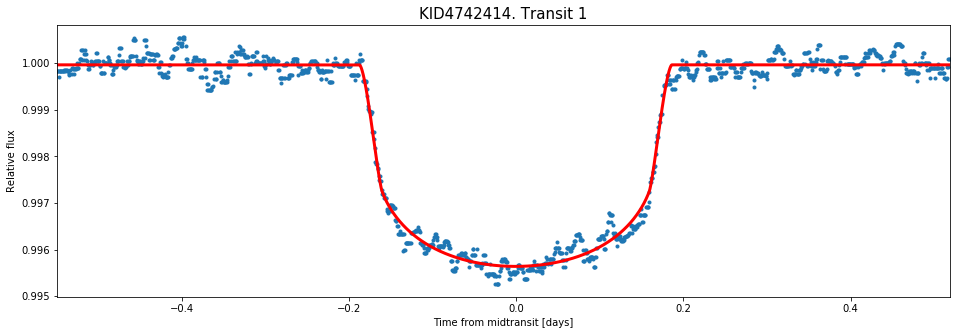

------ Pre-MCMC Results ------
	Transit duration [d]:	 Fit=0.373	True=0.366
	Period [days]:	 Fit=51.27458620	True=15.45805668
	Impact Parameter:	 Fit=0.457819	True=0.050000
	Depth:	 Fit=0.003707	True=0.004253
	Stellar mass:	 Fit=1.063	True=1.066
	Stellar radius:	 Fit=1.417	True=1.407

------ Prepare MCMC -------
Guess of Rp [in Rsun]:  0.08566587803918933
1+rp_guess/rs:  1.060885485457846
Running burn-in


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]



------ Run MCMC -------


100%|██████████| 200/200 [00:40<00:00,  4.92it/s]



------ Post-MCMC Results ------

Depth:
	True = 0.004
	MCMC Fit = 0.004 (+0.000,-0.000)

Impact parameter:
	True = 0.050
	MCMC Fit = 0.459 (+0.001,-0.001)

Planet radius [REarth]:
	True = 9.110
	MCMC Fit = 9.410 (+0.010,-0.011)

Period [d]:
	True = 15.458
	MCMC Fit = 51.325 (+1.047,-0.055)

Inverse of scaled semi-major axis:
	True = 0.0703
	MCMC Fit = 0.0153 (+0.0000,-0.0000)

Stellar radius [Rsun]:
	True = 1.407
	MCMC Fit = 1.417 (+0.001,-0.002)

Stellar Mass [Msun]:
	True = 1.066
	MCMC Fit = 1.063 (+0.016,-0.001)


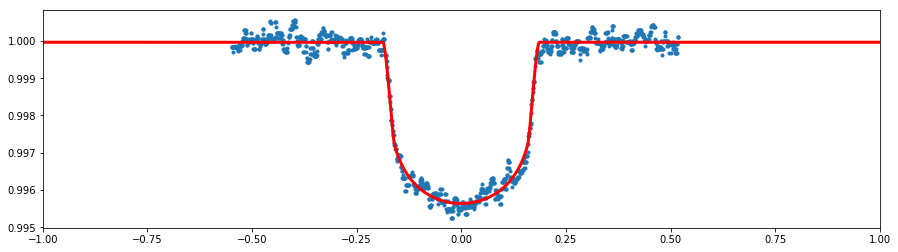

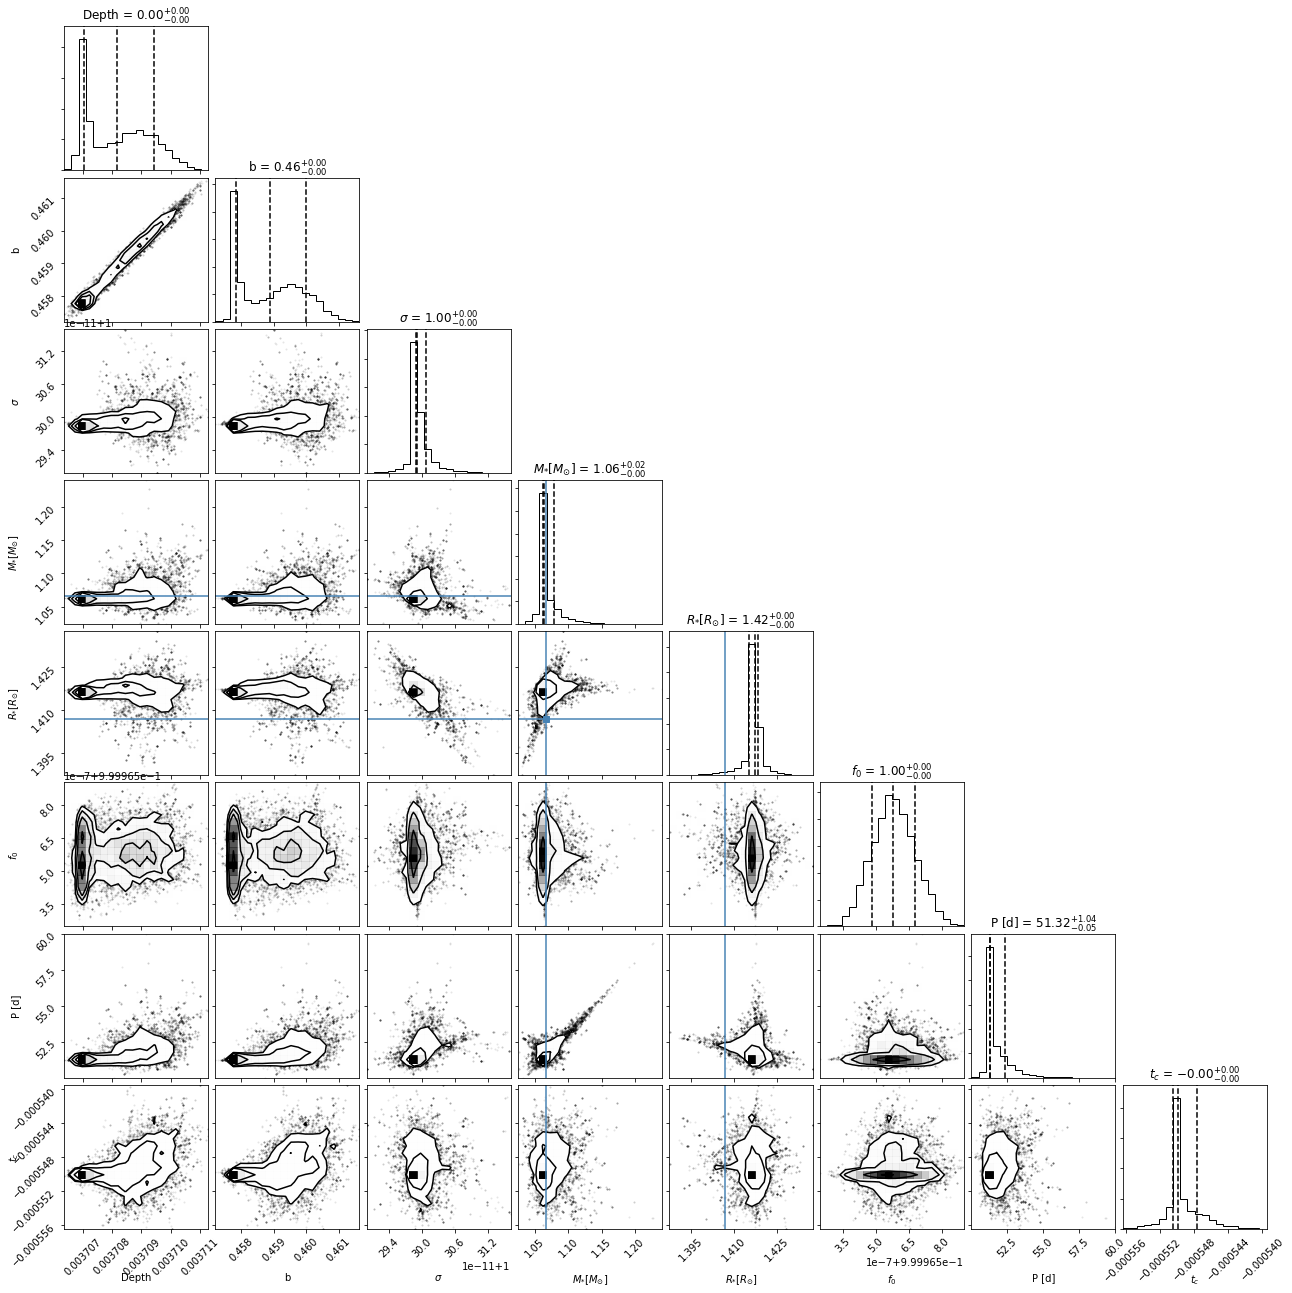

Mean acceptance fraction: 0.47825
Acceptance fraction: 47.83 %


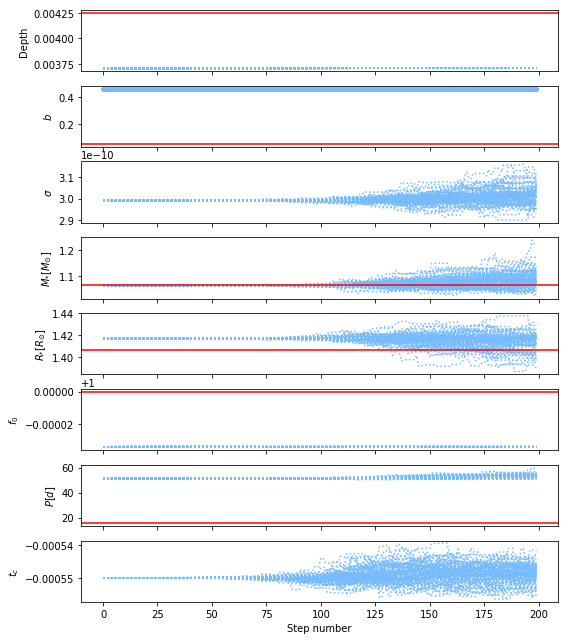

In [36]:
s1 = set(stars_wo_transits)
#great_stars = {5812701, 11391018, 2987027, 4742414}
great_stars = {4742414}

for target in targets:
    if (target.kepid not in s1) and (target.kepid in great_stars): #only consider targets with observed transits
        print("\n******** KID"+str(target.kepid)+" ********")
        transit_range = (amplify*target.duration)/2 # In days 
        missed_trans = set(target.ind_missed_transits)
        print("Transit range [d]:", transit_range)
        
        for i in range(len(target.transit_times)):
            fit_results = []
            period_distributions = []
            MCMC_transits = []
            
            if (i not in missed_trans): #only consider the observed transits, not the missing ones 
                print("\t TRANSIT "+str(i+1))
                dt_trans = target.ttrans[target.trans_id==i]-target.transit_times[i]
                f_trans = target.ftrans[target.trans_id==i] 
                oot = np.abs(dt_trans)>=transit_range
                iit = np.abs(dt_trans)<transit_range
                d = 1-np.mean(f_trans[iit])
                print("\t\td = {0:0.5f}, 1-min(f) = {1:0.5f}".format(d,1-min(f_trans)))
                error_trans = np.std(f_trans[oot])
                print("\t\tError transit = "+str(i+1)+": "+str(error_trans))
                
                res_fit = run_transit_routine(target, dt_trans, f_trans, error_trans, i)
                fit_results.append(res_fit)
                
                period_res, mcmc_res = run_mcmc(target, dt_trans, f_trans, 0.01*error_trans, i, res_fit, 
                                                True, True, True, True, True, True)
                
                period_distributions.append(period_res)
                MCMC_transits.append(mcmc_res)
                
            else: 
                fit_results.append(0)
                period_distributions.append(0)
                MCMC_transits.append(0)
                
        target.res_transfit = fit_results
        target.P_distribution = period_distributions
        target.MCMC_transits = MCMC_transits
        
        locs_P = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
        locs_MCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'
        fname_P = str(target.kepid)+"_st"+str(steps)+"_Pdist.txt"
        fname_MCMC = str(target.kepid)+"_st"+str(steps)+"_MCMC_transits.txt"

        np.savetxt(locs_P+fname_MCMC, np.column_stack((id_mcmc, MCMC_transits[0])), header = header_mcmc, 
                   delimiter=" ", fmt="%s")
        np.savetxt(locs_MCMC+fname_P, np.column_stack(period_distributions), fmt = "%0.15f")


# Old

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.subplot(311)
counts, bins, patches = plt.hist(period_data, density = False, weights = None, histtype='stepfilled',alpha=0.4) #bins = Edges of the bins
pos_highest_bin = np.argmax(counts)
print(len(period_data))
print("Bin {0:s}, which contains periods between {1:.2f} and {2:0.2f} days, is \
more likely to contain the true period.".format(str(pos_highest_bin+1),bins[pos_highest_bin],bins[pos_highest_bin+1]))

mask_period = (period_data >= bins[pos_highest_bin]) & (period_data <= bins[pos_highest_bin+1])
period_candidates = period_data[mask_period == True]
print(len(period_candidates))

plt.subplot(312)
counts_c, bins_c, patches_c = plt.hist(period_candidates, density = False, weights = None, histtype='stepfilled',alpha=0.4) #bins = Edges of the bins
plt.xlabel('Period [days]'); 

pos_highest_bin_c = np.argmax(counts_c)
mask_period_c = (period_candidates >= bins_c[pos_highest_bin_c]) & (period_candidates <= bins_c[pos_highest_bin_c+1])
period_candidates_c = period_candidates[mask_period_c == True]

plt.subplot(313)
counts_cc, bins_cc, patches_cc = plt.hist(period_candidates_c, density = False, weights = None, histtype='stepfilled',alpha=0.4) #bins = Edges of the bins

store_hist= "hist"+str(target_id)
plt.savefig(store_hist+'.png')

In [ ]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
     Gaussian prior: We assume that the parameter we want to fit 
    is constrained within the range centered on the maximum value of a 
    Gaussian distribution. 
    
    """   
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius))
    body = transit.Body(r = np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma**2
    ftheo = s.light_curve(timeLC, texp = tKep, tol = 10e-2, maxdepth = 4)
    ftheo = ftheo - 1.0 + f0
    
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)) +
                 ((pmass-mass)/masserr)**2 + 
                 ((pradius-radius)/radiuserr)**2) # Chi Squared

def lnprior(theta): 
    # This function ensures that our best estimates make physical sense.
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.2 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (pmass > 0):
        return 0.0 
    return -np.inf

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [ ]:
def find_best_fit(system):
    
    perTP_no_Units = np.float(np.copy(system.perTP))
    duration_no_units = np.float(np.copy(system.durationTP))

    allfixed = [perTP_no_Units, system.eccen, system.smass, system.smass_err, 
                system.rs, system.rs_err, system.diffld, tKep]
    
    nll = lambda *args: -lnprob(*args)
 
    # Minimization of the function "nll"
    result = op.minimize(nll, [1.2*system.depthTP, 0.0, 0.0, 0.0, system.u1+system.u2, system.smass, system.rs, 0.0], 
                             args = (np.array(system.folded_time), np.array(system.folded_flux), 
                                     system.rms_ootTP, allfixed),
                             options = {'disp': True}, method  ='Nelder-Mead')
    
    # Store best estimates in "result["x"]
    depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

    system.optimize_loop1 = result["x"]

    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + system.diffld)
    u2_ml = sumLD_ml - u1_ml

    # Compute each transit LC integrated over a Kepler long cadence exposure time 
    # with the result derived from optimization and plot theoretical model and observed data.

    s = transit.System(transit.Central(mu1 = u1_ml, mu2 = u2_ml, mass = mass_ml, radius = radius_ml))

    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = perTP_no_Units, t0 = t0_ml, 
                            b = b_ml, e = system.eccen)

    s.add_body(body)
    t_theory = np.arange(-1.0, 1.0, tKep)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-2, maxdepth = 5)
    f_theory = f_theory - 1.0 + f0_ml
    
    fig = plt.figure()
    plt.plot(24.*system.folded_time, system.folded_flux,'.') 
    plt.plot(24.*t_theory, f_theory,'.')
    plt.title('KID' + str(system.kepid))
    plt.xlabel('Time from midtransit [hours]')
    plt.ylabel('De-trended Flux')
    plt.xlim([-duration_no_units*24., duration_no_units*24.])
    plt.show()
    

In [ ]:
sc = 58.0  #sc = 58 sec -> 
tKep = sc*(1./60.)*(1./60.)*(1./24.)  # sc in days

for system in targets:
    if system.num_planets == 1:
        print "KID"+str(system.kepid)+':'
        find_best_fit(system)
        
        print "Depth:", system.optimize_loop1[0]
        print "Impact parameter:", system.optimize_loop1[1],"vs Kepler reported value:", system.impact
        print "Initial transit time (Phase-folded LC):", system.optimize_loop1[2]
        print "Mass of the star (Solar units):", system.optimize_loop1[5],"vs Kepler reported value:", system.smass
        print "Radius of the star (Solar units):",  system.optimize_loop1[6], "vs Kepler reported value:", system.rs
        print "Out-of-transit flux",  system.optimize_loop1[7],"\n"

## Identify Transits

In [ ]:
def find_transits(system):
    
    t_initial = min(system.time_BKJD)
    t_end = max(system.time_BKJD)
    t0 = system.t
    
    n_min = int((t_initial-t0)/system.per)
    n_max = int((t_end-t0)/system.per+1.)
    n = np.arange(n_min, n_max)

    transit_times = t0+n*system.per
    transit_times = transit_times[transit_times>t_initial] 
    transit_times = transit_times[transit_times<t_end]
    system.transits = transit_times
    
    #print "Transits should occur at:", system.transits,"\n"

In [ ]:
def fold(system):
    #Returns time values ranging between -"transit_range" to +"transit_range". Data points 
    #which occur exactly at ``phase`` or an integer multiple of `phase + n*period` have time value 0.0. 
    #Note: transit window = 2*transit_range
    
    phase = system.time0bk
    transit_range = (system.duration)/2.
    print "Transit range:", transit_range
    
    fold_time = ((system.time_BKJD-phase+transit_range*system.per)/system.per)%1-transit_range
    sorted_args = np.argsort(fold_time)   
    system.foldedTime = fold_time[sorted_args]
    system.flux = system.flux[sorted_args]
    system.flux_err = system.flux_err[sorted_args] 

In [ ]:
for target in targets:
        print("\n******\t"+str(target.kepid)+"******")
        
        print(len(target.time_BKJD))
        total_days = target.time_BKJD.iloc[-1]-target.time_BKJD.iloc[0]
        one_day = np.abs(int(len(target.time_BKJD)/total_days))
        sensitivity = 2
        min_peak_dist = one_day*sensitivity
        target.peaks = run_peak_filter(target, min_peak_dist, plot = True)
        
        num_peaks = len(target.peaks[:,2])
         
        final_peaks = np.copy(target.peaks)
        tpeaks = [None]*num_peaks
        fpeaks = [None]*num_peaks
        fpeaks_err = [None]*num_peaks
        
        #Explore peak-by-peak and discard those which are too noisy or unclear
        for i in range(num_peaks):
            pos_peak, t_peak, f_peak = int(target.peaks[i,0]), int(target.peaks[i,1]), target.peaks[i,2]
            if (i!=num_peaks-1): 
                dist_from_transit = int((target.peaks[i+1,0]-pos_peak)/2) #todo: average separation b/w peaks
            else: 
                dist_from_transit = int((pos_peak-target.peaks[i-1,0])/2)
            
            if (dist_from_transit/one_day > 1.0): dist_from_transit = int(one_day)
            dist_from_transit = int(one_day)
            print("Transit range [d]:", dist_from_transit/one_day)
            
            t_zoom = (target.time_BKJD[pos_peak-dist_from_transit:pos_peak+dist_from_transit]).values
            f_zoom = (target.flux[pos_peak-dist_from_transit:pos_peak+dist_from_transit]).values
            f_err_zoom = (target.flux_err[pos_peak-dist_from_transit:pos_peak+dist_from_transit]).values

            corr_f_zoom = sig.medfilt(f_zoom, 9)
            time_max_peak = np.argmin(corr_f_zoom)
            tc = t_zoom[time_max_peak]

            # Subtract time offset
            t_zoom-=tc

            #Select [-1,1] interval
            mask_int = (t_zoom > -1) & (t_zoom < 1)
            t_zoom_mask = t_zoom[mask_int==True]
            corr_f_zoom_mask = corr_f_zoom[mask_int==True]
            corr_f_zoom_err_mask = f_err_zoom[mask_int==True]

            tpeaks[i] = t_zoom_mask 
            fpeaks[i] = corr_f_zoom_mask 
            fpeaks_err[i] = corr_f_zoom_err_mask 
 
            #print(np.median(corr_f_zoom_mask),np.mean(corr_f_zoom_mask),np.std(corr_f_zoom_mask))

            """
            if (int(np.mean(corr_f_zoom_mask))>1):
                print('\tPeak {:s} is unclear or too noisy -- disregard it.'.format(str(i+1)))
                final_peaks[i,:]=0.0
                tpeaks[i], fpeaks[i], fpeaks_err[i] = 0, 0, 0
            """
            plt.figure()
            plt.title('Transit %s'%str(i+1))
            plt.plot(t_zoom_mask,corr_f_zoom_mask,'.')
            plt.show(block=False)
            time.sleep(1)
            plt.close()
                
        bad_peaks = (final_peaks==0.0).all(1)
        target.peaks = final_peaks[bad_peaks == False]
        bad_peaks_indx = np.where(bad_peaks)[0]

        for index in sorted(bad_peaks_indx, reverse=True):
            del tpeaks[index]
            del fpeaks[index]
            del fpeaks_err[index]

        target.tpeaks  = tpeaks
        target.fpeaks = fpeaks
        target.fpeaks_err = fpeaks_err

        print("Nº of peaks (updated):", len(target.peaks[:,0]))

def run_peak_filter(star, mpd, plot):
    pos_drops, _ = sig.find_peaks(-star.flux, distance=mpd)
    
    flux_drops = star.flux[pos_drops]
    drops = np.column_stack((pos_drops, flux_drops))
    
    print("Nº of peaks (before mask):",len(flux_drops))
    time_max_flux_drop = (flux_drops).idxmin(axis=None, skipna=True)
    depth_guess = 1-min(flux_drops)
        
    mask_drops = min(flux_drops)+depth_guess*(1/2)
    keep_drops = drops[:,1]<=mask_drops
        
    print("\tRemove peaks > than", mask_drops)
    drops_mask = drops[keep_drops==True]
    print("Nº of peaks (after mask):",len(drops_mask[:,1]))
    
    final_peaks = np.column_stack((drops_mask[:,0],star.time_BKJD[drops_mask[:,0]].values, drops_mask[:,1]))
    
    #Check if the first peak is too close to the start or end of the cadence 
    pos_peak_i = int(final_peaks[0,0])
    pos_peak_f = int(final_peaks[-1,0])
    
    dist_transit_i = (final_peaks[1,0]-final_peaks[0,0])/2
    dist_transit_f = (final_peaks[-1,0]-final_peaks[-2,0])/2
    
    if (pos_peak_i-dist_transit_i < 0): 
        final_peaks = np.delete(final_peaks, 0, axis=0)
        
    if (pos_peak_f+dist_transit_f>star.time_BKJD.iloc[-1]):  
        final_peaks = np.delete(final_peaks, -1, axis=0)
    
    #Print the updated number of peaks
    print("Nº of peaks (after checking ends):", len(final_peaks[:,0]))
    
    if (plot == True):
        plt.figure(figsize=(15,10))
        plt.title('KID'+str(star.kepid))
        plt.plot(star.time_BKJD, star.flux,'.',star.time_BKJD[drops[:,0]],drops[:,1],'ro')
        plt.subplot(2,1,1)
        plt.ylabel('Flux'); plt.xlabel('Time BKJD')
        plt.plot(star.time_BKJD, star.flux,'.',star.time_BKJD[drops[:,0]],drops[:,1],'ro')
        plt.subplot(2,1,2)
        plt.ylabel('Flux'); plt.xlabel('Time BKJD')
        plt.plot(star.time_BKJD, star.flux,'.',final_peaks[:,1],final_peaks[:,2],'ro')
        plt.axhline(y=mask_drops, color='k', linestyle='-')
        plt.show(block=False)
        time.sleep(1)
        plt.close()
        
    return(final_peaks)

In [ ]:
def fold(star):
    #Returns time values ranging between -"transit_range" to +"transit_range". Data points 
    #which occur exactly at ``phase`` or an integer multiple of `phase + n*period` have time value 0.0. 
    #Note: transit window = 2*transit_range
    
    phase = star.time0bk
    transit_range = (star.duration)/2.
    print("Transit range:", transit_range)
    
    fold_time = ((star.time_BKJD-phase+transit_range*star.P)/star.P)%1-transit_range
    sorted_args = np.argsort(fold_time)   
    #star.foldedTime = fold_time[sorted_args]
    #system.flux = system.flux[sorted_args]
    #system.flux_err = system.flux_err[sorted_args] 

In [ ]:
def colTrans(system):
    color_code = plt.figure(figsize=(17,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    for i in range(0,len(system.transits)):
        transitBool = (system.flag == i)
        
        if i % 2 == 0: #even transit
            ax1.plot(system.t_trans[transitBool], system.f_trans[transitBool], '.', color = 'red', label = 'Even')
            ax2.plot(system.dt[transitBool], system.f_trans[transitBool],'.', color = 'red', label = 'Even')
        else:
            ax1.plot(system.t_trans[transitBool], system.f_trans[transitBool], '.', color = 'green', label = 'Odd')
            ax2.plot(system.dt[transitBool], system.f_trans[transitBool],'.', color = 'green', label = 'Odd')
    
    ax1.legend(); ax2.legend(); 
    ax1.set_title('KID'+ str(system.kepid), fontsize = 14); 
    ax2.set_title('Folded LC for KID'+ str(system.kepid), fontsize = 14)
    ax1.set_ylabel('Normalized Flux');
    ax1.set_xlabel('BJD-2454833 (days) '); ax2.set_xlabel('Time from midtransit (days)')

In [ ]:
from collections import OrderedDict

def export_folded_lc(system, fraction):
    len_file = len(system.f_trans)
    cut = random.sample(zip(system.f_trans, system.f_trans_err, system.dt), int(fraction*len_file/100))
    cut_flux, cut_flux_err, cut_time = zip(*cut)
    
    system.dt = np.array(cut_time) #use np.array to convert from tuple to array
    system.f_trans = np.array(cut_flux)
    system.f_trans_err = np.array(cut_flux_err)
    
    cut_fold_lc = pd.DataFrame(OrderedDict({'Phase': cut_time, 'Flux': cut_flux, 'Flux_Err': cut_flux_err}))
     
    np.savetxt('/Users/mbadenas/Documents/Master UAB/Tesis UAB/folded_LC/cut'+str(fraction) \
               +'_fold_KID'+str(system.kepid)+'.txt', 
               cut_fold_lc.values, fmt='%f', delimiter="\t", header="Phase\t\tFlux (normalized)\t\tFlux error") 

In [ ]:
cut_fraction = 50 #in %. If 100, the entire light curve is used.
one_planet = 0

for system in targets:
    if system.num_planets==1:
        find_transits(system)
        fold(system)
        transit_window(system)
        
        fig = plt.figure(figsize=(17,5))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
    
        ax1.plot(system.time_BKJD, system.flux,'.')
        ax1.plot(system.transits, np.ones(len(system.transits))*min(system.flux),'ro')  
        ax1.set_xlabel('BJD-2454833 (days)'); 
        ax1.set_ylabel('Normalized Flux'); 
        ax1.set_title('KID'+str(system.kepid)); 
        
        ax2.plot(system.foldedTime, system.flux,'.')
        ax2.set_xlabel('Time from midtransit (days)'); 
        ax2.set_ylabel('Normalized Flux')
        ax2.set_title('Folded LC for '+str(system.kepid)) 
        
        colTrans(system)
        export_folded_lc(system, cut_fraction)
        
        one_planet += 1

## Theoretical model

Todo: standard dev of out-of-transit flux for each identified transit 